### Initiation

In [1]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For statistics
from scipy import stats

# Import trackArrayTools
from trackArrayTools import *

#rSNAPsim_IP
cwd = os.getcwd()  # get current working director
os.chdir('../rSNAPsim_IP/rSNAPsim_IP/') # assume rSNAPsim_IP is  one directory up
import rSNAPsim_IP as rss_IP #importing rSNAPsim.
os.chdir(cwd) # change back to original current directory (the directory this file is in)

Error importing cv2, the manual selection for the mask will not work.
         _____ _   _____    ____       _              ________ 
   _____/ ___// | / /   |  / __ \_____(_)___ ___     /  _/ __ \
  / ___/\__ \/  |/ / /| | / /_/ / ___/ / __ `__ \    / // /_/ /
 / /   ___/ / /|  / ___ |/ ____(__  ) / / / / / /  _/ // ____/ 
/_/   /____/_/ |_/_/  |_/_/   /____/_/_/ /_/ /_/  /___/_/      
                                                               



### Set current working directory, track array filenames, and basic parameters

In [2]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/'
video_3D_filename_path = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/'
beads_path ='C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/beads/'
video_3D_filename = 'XBP1_HT_60TP_60sINT_MMStack_Pos5.tif'

In [3]:
# For display, so z and xy are shown properly when viewing track array
z_renorm = z_pixel_size/xy_pixel_size  

#  Track array filenames should be the following:
track_array_filename = 'Particles_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
track_filename = track_array_filename[:-15] + '.csv'
[track_array_filename, track_filename]

['Particles_XBP1_HT_60TP_60sINT_MMStack_Pos5_crop_pad_5.tif',
 'Particles_XBP1_HT_60TP_60sINT_MMStack_Pos5.csv']

### Creating Track Array (only done once using original 3D video and tracks)

In [4]:
# Loading the figure with beads so track array can be registered
# Dimension 1 is the number of channel. Red and Green. # Dimension 2 is the x axis. # Dimension 3 is the y axis.
figWithBeads = beads_path + 'Beads01.tif'
im_beads = io.imread(figWithBeads) # reading the image

In [5]:
# Using rSNAPSim to get the homography matrix to align the green/blue channels with red
temp_obj_beads = rss_IP.BeadsAlignment(im_beads)
[my_homography,positions_green,positions_red] = temp_obj_beads.make_beads_alignment()  # !!! Adjusted Luis' code to spit this info out

The number of spots detected for the red channel are:
(20, 2)
The number of spots detected for the green channel are:
(20, 2)

The homography matrix is:


In [6]:
# Check that the homography matrix is working:
my_homography_inverse = np.linalg.inv(my_homography)  # This is the transformation we use to shift green to red
print('[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]' )
for i in np.arange(len(positions_green)):
    g0=positions_green[i]
    g=np.dot(my_homography_inverse,[positions_green[i,0],positions_green[i,1],1])[0:2]  # Correct green/blue
    r0=positions_red[i]
    r=np.dot(my_homography,[positions_red[i,0],positions_red[i,1],1])[0:2]  # What you'll do: shift red to green
    print([np.linalg.norm(g0-r0),np.linalg.norm(g0-r),np.linalg.norm(g-r0)]) # Check corrections

[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]
[1.2726687, 0.12849299313417575, 0.1280740294164543]
[1.3451809, 0.14853664364314356, 0.14807651895121135]
[2.0753744, 0.15718788109963497, 0.1565058976266831]
[1.3255992, 0.055842676707769115, 0.05569601027254516]
[2.6797066, 0.20342482110419635, 0.2029440438445857]
[1.2187791, 0.1008292573351438, 0.1005412498271081]
[1.71802, 0.2992409694149052, 0.2987281485993548]
[2.667532, 0.15109284469553486, 0.15072017167476776]
[1.3152245, 0.2709841342835561, 0.2700017522510797]
[1.7368447, 0.19023605921109252, 0.18938879727843283]
[2.4173877, 0.16530609314268166, 0.1649267292683264]
[3.002502, 0.32696980496345995, 0.32600086152091323]
[2.736199, 0.3452139957795221, 0.34386731413269855]
[2.0486274, 0.218367777388381, 0.2176507089231217]
[2.8950522, 0.19863269305190143, 0.1982603587722709]
[2.1219773, 0.348756247935226, 0.34739027811796314]
[2.1285346, 0.10154393145179892, 0.1010662897799378]
[2

In [7]:
video_3D_filename_path+video_3D_filename

'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/XBP1_HT_60TP_60sINT_MMStack_Pos5.tif'

In [8]:
# Read in the original 3D video 
video_3D = imread(video_3D_filename_path+video_3D_filename)

In [9]:
# Create track array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with track array itself
video_3D = imread(video_3D_filename_path + video_3D_filename)
dims = list(video_3D.shape)
if len(dims) == 4:     # check if just a single channel video
    n_channels = 1
    n_frames, z_slices, height_y, width_x = dims
else:
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)   # find index of n_channels, which is assumed to be smallest dimension 
    dims.remove(n_channels)    
    video_3D = np.moveaxis(video_3D,n_channels_index,-1)  # move channels to last dimension of array (assumed by napari)
    n_frames, z_slices, height_y, width_x = dims

In [10]:
# Read in the tracking file that corresponds to the original 3D video
tracks = pd.read_csv(video_3D_filename_path+track_filename) 
tracks.head()

,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
0,ID114720,114720,0,163.716,336.810,271.316,6.851,0,0,4,...,-10921639,748.836,739,517,1100,255353,98.453,15.200,0.024,0.359
1,ID114929,114929,0,115.187,337.849,275.219,7.743,1,1,4,...,-10921639,737.267,733,533,1096,251408,77.879,14.274,0.019,0.357
2,ID114690,114690,1,193.946,234.691,248.097,4.618,0,0,4,...,-10921639,849.088,840,566,1303,289539,111.353,12.088,0.031,0.453
3,ID114875,114875,1,152.193,237.643,242.523,2.998,1,1,4,...,-10921639,842.569,830,606,1229,287316,95.259,15.200,0.036,0.612
4,ID114782,114782,1,128.812,234.322,240.430,3.992,2,2,4,...,-10921639,815.114,803,554,1167,277954,97.636,13.684,0.020,0.321


In [12]:
viewer = napari.Viewer()
viewer.add_image(video_3D[:,:,:,:,0],name='red',blending="additive", scale=[z_renorm,1,1])
viewer.add_tracks(tracks[['TRACK_ID','POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']].values, name="TRACK_IDs")

<Tracks layer 'TRACK_IDs' at 0x19f67f6db88>

In [13]:
create_particle_array_video(working_directory, track_array_filename, video_3D, 
                             tracks, crop_pad, xy_pixel_size, z_pixel_size, homography = my_homography)
# create_track_array_video(working_directory, track_array_filename, video_3D[0::10], tracks, crop_pad, xy_pixel_size, z_pixel_size)

### Track Array analysis: 3D background subtract + best-z projection + 2D background subtract

In [14]:
# Choose which track array you want to work with:
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/'
track_array_filename ='Particles_XBP1_HT_60TP_60sINT_MMStack_Pos5_crop_pad_5.tif'

# The corresponding tracking file should be in the same directory and have the following filename: 
track_filename = track_array_filename[:-15] + '.csv'

# Read in the track array video 
track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

# Read in tracks as a "dataframes (df)"
track_array_df = pd.read_csv(working_directory + track_filename)

# Make sure color channels are the last dimension of the track array
dims = list(track_array_vid.shape)
if len(dims) != 3:     # check if just a single channel video
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)
    track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

In [15]:
# Step 0: Create the track array object:
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

In [25]:
# Step 1: subtract background in 3D capsule mask
my_offset = [0,-1,-1]  ### For 3-color, could be [0,-1,-1]; BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)

# Check with napari
max = np.max(arr_bg,axis=(0,1,2)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(arr_bg,[z_renorm,1,1],int_range=my_range,layer=[capsule_mask[:,:,:,0],capsule_mask[:,:,:,1]])

In [18]:
# Step 2: Now do best-z projection
my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
arr_bg_best_z = ta.mask_projection(arr_bg, my_best_z_masks) # best-z projection

# Check with napari
max = np.max(arr_bg_best_z,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(arr_bg_best_z,[1,1],int_range=my_range)

In [19]:
# Step 3: Subtract background in donut rings from max projection  
arr_bg_best_z_bg = ta.local_background_subtract(arr_bg_best_z,ta.donut_mask_2D(5,1))

# Check with napari and show donut mask
max = np.max(arr_bg_best_z_bg,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(arr_bg_best_z_bg,[1,1],int_range=my_range,layer=[ta.donut_mask_2D(5,1)])

In [20]:
# Output background-subtracted and max-z projected track array 
output_filename_path = working_directory + track_array_filename[0:-4] + '_bg-sub_bestz_bg-sub.tif'
io.imsave(output_filename_path,
        arr_bg_best_z_bg, 
        resolution=(1/xy_pixel_size,1/xy_pixel_size))
output_filename_path

'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/Particles_XBP1_HT_60TP_60sINT_MMStack_Pos5_crop_pad_5_bg-sub_bestz_bg-sub.tif'

In [28]:
# Loop everything above on a collection of images, if desired:
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/'
vids = ['XBP1_HT_60TP_60sINT_MMStack_Pos5.tif','XBP1_HT_60TP_60sINT_MMStack_Pos5-2.tif'] # Add to this list to batch process
my_offset = [0,-1,-1]  ### BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
for vs in vids:
    # Get track array video and tracking files:
    track_array_filename = 'Particles_'+vs[0:-4]+'_crop_pad_5.tif'
    track_filename = track_array_filename[:-15] + '.csv'

    # Read in the track array video 
    track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

    # Read in tracks as a "dataframes (df)"
    track_array_df = pd.read_csv(working_directory + track_filename)

    # Make sure color channels are the last dimension of the track array
    dims = list(track_array_vid.shape)
    if len(dims) != 3:     # check if just a single channel video
        n_channels = min(dims)
        n_channels_index = dims.index(n_channels)
        track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

    # Step 0: make the track array object
    ta = TrackArray(track_array_vid, track_array_df, crop_pad)

    # Step 1: subtract background in 3D capsule mask
    my_offset = [0,-1,-1]  # !!!! This should probably be defaulted as [0,0,0]
    capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
    arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)
    
    # Step 2: Now do best-z projection
    my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
    arr_bg_best_z = ta.mask_projection(arr_bg, my_best_z_masks) # best-z projection
    
    # Step 3: Subtract background in donut rings from max projection  
    arr_bg_best_z_bg = ta.local_background_subtract(arr_bg_best_z,ta.donut_mask_2D(5,1))

    # Output background-subtracted and max-z projected track array 
    output_filename_path = working_directory + track_array_filename[0:-4] + '_bg-sub_bestz_bg-sub.tif'
    io.imsave(output_filename_path,
            arr_bg_best_z_bg, 
            resolution=(1/xy_pixel_size,1/xy_pixel_size))

### Concatentate all track arrays of interest into one giant track array object

In [29]:
# Specify basic track array parameters (in case not done above)
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension

# Specify working directory and files you want to read in:
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts/TestData/'
vids_TA =['XBP1_HT_60TP_60sINT_MMStack_Pos5.tif','XBP1_HT_60TP_60sINT_MMStack_Pos5-2.tif'] 
vids_TL =['XBP1_HT_60TP_60sINT_MMStack_Pos5.tif'] 
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
#track_array_filenames = ['Tracks_' + videos[:-4] + '_crop_pad_' + 
#                          str(crop_pad) + '.tif' for videos in vids]
track_array_filenames_TA = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bg-sub_bestz_bg-sub.tif' for videos in vids_TA]
track_array_filenames_TL = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bg-sub_bestz_bg-sub.tif' for videos in vids_TL]

In [30]:
# Read in all track array videos and corresponding tracking files:
track_array_vids_TA = [imread(working_directory + i) for i in track_array_filenames_TA]  # Read in track array .tif file
track_files_TA = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') for videos in vids_TA] 

track_array_vids_TL = [imread(working_directory + i) for i in track_array_filenames_TL]  # Read in track array .tif file
track_files_TL = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') for videos in vids_TL] 

# Concatentate the tracking files:
tracks_all_TA = pd.concat(track_files_TA, axis=0, sort=False) 
tracks_all_TL = pd.concat(track_files_TL, axis=0, sort=False) 

# Concatenate the tracking_array_vids:
track_array_all_TA = concat_crop_array_vids(track_array_vids_TA)
track_array_all_TL = concat_crop_array_vids(track_array_vids_TL)

# Make large, single track array:
ta_TA = TrackArray(track_array_all_TA, tracks_all_TA, crop_pad)
ta_TL = TrackArray(track_array_all_TL, tracks_all_TL, crop_pad)

In [31]:
# View the background-subtracted track array and disk mask to measure intensities in:
napari_viewer(ta_TA.moving_avg(ta_TA.arr,1),[1,1],int_range=[[0,10000] for i in np.arange(ta_TA.n_channels())],
              layer=[ta_TA.donut_mask_2D(3,1),ta_TA.disk_mask_2D(3)])

In [71]:
# View the background-subtracted track array and disk mask to measure intensities in:
napari_viewer(ta_TL.moving_avg(ta_TL.arr,1),[1,1],int_range=[[0,10000] for i in np.arange(ta_TA.n_channels())],
              layer=[ta_TL.donut_mask_2D(3,1),ta_TL.disk_mask_2D(3)])

### Figures generated from the concatenated track array object

In [32]:
# Choose working directory where you want to save figures and data:
os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/Plots/')

In [34]:
# Cacluate the intensity in the disk mask of radius 3 (this is the mask viewed above)
my_int_TA = ta_TA.int_in_mask(ta_TA.arr,np.array([ta_TA.disk_mask_2D(3)]))
my_int_TL = ta_TL.int_in_mask(ta_TL.arr,np.array([ta_TL.disk_mask_2D(3)]))

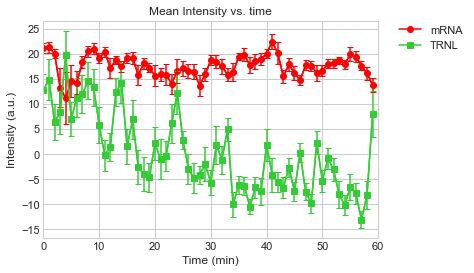

In [35]:
# Plot the mean intensity as a function of time (essentially this is the Harringtonine curve).
# Note this saves the plot to the specified filename (should be a .svg filename) to the workign directory.
# As well, a .csv file containing the plot data will be generated with the same filename.
my_arr = my_int_TA # Choose track array
delta_t = 1 
my_times = np.arange(my_arr.shape[1])*delta_t
my_mean_intensity_plot(np.ma.masked_equal(my_arr,0),channels=[0,1],labels=['mRNA','TRNL'],xlim=[0,60],
               colors=['red','limegreen'],markers=['o','s'],renorm=False, error='sem', 
                       style='seaborn-whitegrid', axeslabels=['Time (min)', 'Intensity (a.u.)'],
                       times = my_times, filename='test.svg')